<a href="https://colab.research.google.com/github/vuducanh0802/data-mining_projects/blob/main/SCL-AEE/SCL_AEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Competition**

**Background** <br>
At Shopee, we strive to ensure our customers' highest satisfaction for their shopping and delivery experience - fast and accurate delivery of goods. This can be better achieved if we have key address elements for each user address which allows us to accurately geocode it to obtain geographic coordinates to ship the parcel to our customers. These key address elements include Point of Interest (POI) Names and Street Names. However, most addresses that Shopee receives are unstructured and in free text format, not following a certain pattern. Thus it is important for us to develop a model to precisely extract the key address elements from it.

**Task**<br>
In this competition, you’ll work on addresses collected by us to build a model to correctly extract Point of Interest (POI) Names and Street Names from unformatted Indonesia addresses.

Participants are expected to build their own model for this competition, submissions by teams which directly call any third party APIs on the test set will not be taken into consideration.

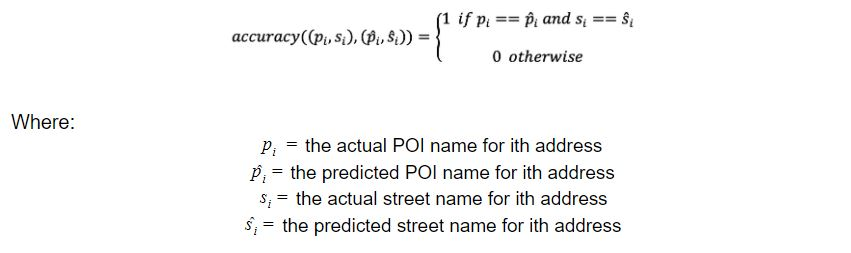

There are addresses with missing POI or street elements. For such cases, you should leave it empty for that specific element of that address. The formula for the overall metric is defined as the average of accuracy score for each address as following:



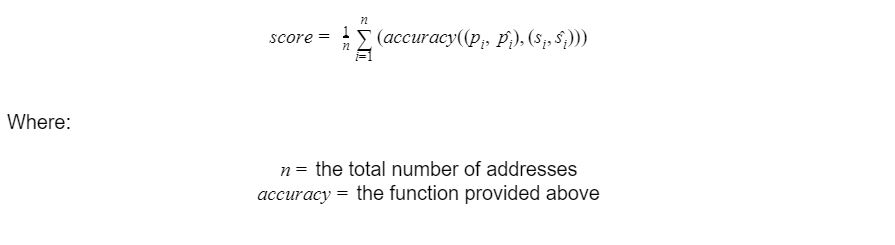

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

from tqdm import tqdm

In [11]:
train = pd.read_csv("/content/drive/MyDrive/DATA/SCL/train.csv")
train.head()

,id,raw_address,POI/street
0,0,jl kapuk timur delta sili iii lippo cika 11 a ...,/jl kapuk timur delta sili iii lippo cika
1,1,"aye, jati sampurna",/
2,2,setu siung 119 rt 5 1 13880 cipayung,/siung
3,3,"toko dita, kertosono",toko dita/
4,4,jl. orde baru,/jl. orde baru


In [12]:
test = pd.read_csv("/content/drive/MyDrive/DATA/SCL/test.csv")
test.head()

,id,raw_address
0,0,s. par 53 sidanegara 4 cilacap tengah
1,1,"angg per, baloi indah kel. lubuk baja"
2,2,"asma laun, mand imog,"
3,3,"ud agung rej, raya nga sri wedari karanganyar"
4,4,"cut mutia, 35 baiturrahman"


#**Split address into 2 part (train data)**

In [13]:
splitstring = train["POI/street"].str.partition('/')
train["POI"] = splitstring[0]
train["street"] = splitstring[2]

train.head()

,id,raw_address,POI/street,POI,street
0,0,jl kapuk timur delta sili iii lippo cika 11 a ...,/jl kapuk timur delta sili iii lippo cika,,jl kapuk timur delta sili iii lippo cika
1,1,"aye, jati sampurna",/,,
2,2,setu siung 119 rt 5 1 13880 cipayung,/siung,,siung
3,3,"toko dita, kertosono",toko dita/,toko dita,
4,4,jl. orde baru,/jl. orde baru,,jl. orde baru


#**Tokenize**

In [14]:
from textblob import TextBlob

train["tokenize"] = train["raw_address"].map(lambda x: TextBlob(x).words)
train["tokenizedPOI"] = train["POI"].map(lambda x: TextBlob(x).words)
train["tokenizedStreet"] = train["street"].map(lambda x: TextBlob(x).words)

test["tokenize"] = test["raw_address"].map(lambda x: TextBlob(x).words)

In [15]:
train.head()

,id,raw_address,POI/street,POI,street,tokenize,tokenizedPOI,tokenizedStreet
0,0,jl kapuk timur delta sili iii lippo cika 11 a ...,/jl kapuk timur delta sili iii lippo cika,,jl kapuk timur delta sili iii lippo cika,"[jl, kapuk, timur, delta, sili, iii, lippo, ci...",[],"[jl, kapuk, timur, delta, sili, iii, lippo, cika]"
1,1,"aye, jati sampurna",/,,,"[aye, jati, sampurna]",[],[]
2,2,setu siung 119 rt 5 1 13880 cipayung,/siung,,siung,"[setu, siung, 119, rt, 5, 1, 13880, cipayung]",[],[siung]
3,3,"toko dita, kertosono",toko dita/,toko dita,,"[toko, dita, kertosono]","[toko, dita]",[]
4,4,jl. orde baru,/jl. orde baru,,jl. orde baru,"[jl, orde, baru]",[],"[jl, orde, baru]"


In [16]:
test.head()

,id,raw_address,tokenize
0,0,s. par 53 sidanegara 4 cilacap tengah,"[s, par, 53, sidanegara, 4, cilacap, tengah]"
1,1,"angg per, baloi indah kel. lubuk baja","[angg, per, baloi, indah, kel, lubuk, baja]"
2,2,"asma laun, mand imog,","[asma, laun, mand, imog]"
3,3,"ud agung rej, raya nga sri wedari karanganyar","[ud, agung, rej, raya, nga, sri, wedari, karan..."
4,4,"cut mutia, 35 baiturrahman","[cut, mutia, 35, baiturrahman]"


#**Fasttext**

In [17]:
x = pd.concat([train.tokenize, test.tokenize], axis=0)
x.head()

0    [jl, kapuk, timur, delta, sili, iii, lippo, ci...
1                                [aye, jati, sampurna]
2        [setu, siung, 119, rt, 5, 1, 13880, cipayung]
3                              [toko, dita, kertosono]
4                                     [jl, orde, baru]
Name: tokenize, dtype: object

In [18]:
import gzip
import gensim 
import logging
import warnings

#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
warnings.filterwarnings('ignore')

#train the model
model = gensim.models.FastText(
    x,
    size=10, 
    window=2, 
    min_count=1, 
    workers=10, 
    sg = 0, 
    iter=100
  )

In [19]:
longest = 0

for _, row in train.iterrows():
    if longest < len(row.tokenize): longest = len(row.tokenize)

print("train max token: ", longest)

longest = 0

for _, row in test.iterrows():
    if longest < len(row.tokenize): longest = len(row.tokenize)

print("test max token: ", longest)

train max token:  32
test max token:  26


In [20]:
TRAIN_DATA = []
TRAIN_LABEL = []

for _, row in train.iterrows():
    temp = []
    templabel = []

    count = 0
    for word in row["tokenize"]:
        temp.append(np.array(model[word]))
        count = count + 1
        if(word in row['tokenizedPOI']):
            templabel.append(np.array([1,0,0,0])) # POI (if else prioritize POI, either i am too lazy or the the time constraining me hard)
        elif(word in row['tokenizedStreet']):
            templabel.append(np.array([0,1,0,0])) # street
        else:
            templabel.append(np.array([0,0,1,0])) # not POI or Street

    if(count != 32):
        for i in range(32-count):
            temp.append(np.zeros(10))
            templabel.append(np.zeros(4))

    TRAIN_DATA.append(np.array(temp))
    TRAIN_LABEL.append(np.array(templabel))

In [21]:
TRAIN_DATA = np.asarray(TRAIN_DATA)
TRAIN_DATA.shape

(300000, 32, 10)

In [22]:
TRAIN_LABEL = np.asarray(TRAIN_LABEL)
TRAIN_LABEL.shape

(300000, 32, 4)

In [23]:
TEST_DATA = []

for _, row in test.iterrows():
    temp = []
    count = 0
    for word in row["tokenize"]:
        temp.append(np.array(model[word]))
        count = count + 1

    if(count != 32):
        for i in range(32-count):
            temp.append(np.zeros(10))

    TEST_DATA.append(np.array(temp))

In [24]:
TEST_DATA = np.asarray(TEST_DATA)
TEST_DATA.shape

(50000, 32, 10)

In [25]:
np.save("./shopee_train_data",TRAIN_DATA )
np.save("./shopee_train_label",TRAIN_LABEL )
np.save("./shopee_test_data",TEST_DATA )

In [27]:
TRAIN_DATA = np.load("shopee_train_data.npy")
TRAIN_LABEL = np.load("shopee_train_label.npy")
TEST_DATA = np.load("shopee_test_data.npy")

#**Train and Validation**

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(TRAIN_DATA, TRAIN_LABEL, test_size=0.2)

#**Bi-LSTM**

In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input

input_layer = Input(
    shape= (32, 10),
    name='input'
)

dropout_layer = Dropout(0.1)(input_layer)

bilstm_layer = Bidirectional(LSTM(units=100, return_sequences=True))(dropout_layer)

output_layer = TimeDistributed(Dense(4, activation="softmax"))(bilstm_layer)

model = Model(inputs=[input_layer], outputs=[output_layer])

model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  sample_weight_mode='temporal',
  metrics=['accuracy']
)

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 10)]          0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 10)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 32, 200)           88800     
_________________________________________________________________
time_distributed (TimeDistri (None, 32, 4)             804       
Total params: 89,604
Trainable params: 89,604
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(
  x = X_train, 
  y = y_train, 
  validation_data = (X_val, y_val),
  epochs = 25,
  initial_epoch = 0
)

Epoch 1/25
7500/7500 [==============================] - 53s 6ms/step - loss: 0.0975 - accuracy: 0.2075 - val_loss: 0.0853 - val_accuracy: 0.2506
Epoch 2/25
7500/7500 [==============================] - 46s 6ms/step - loss: 0.0878 - accuracy: 0.3861 - val_loss: 0.0819 - val_accuracy: 0.3425
Epoch 3/25
7500/7500 [==============================] - 45s 6ms/step - loss: 0.0851 - accuracy: 0.4560 - val_loss: 0.0798 - val_accuracy: 0.3601
Epoch 4/25
7500/7500 [==============================] - 45s 6ms/step - loss: 0.0836 - accuracy: 0.4529 - val_loss: 0.0793 - val_accuracy: 0.5570
Epoch 5/25
7500/7500 [==============================] - 45s 6ms/step - loss: 0.0826 - accuracy: 0.5060 - val_loss: 0.0785 - val_accuracy: 0.4629
Epoch 6/25
7500/7500 [==============================] - 45s 6ms/step - loss: 0.0818 - accuracy: 0.4866 - val_loss: 0.0781 - val_accuracy: 0.4386
Epoch 7/25
7500/7500 [==============================] - 45s 6ms/step - loss: 0.0813 - accuracy: 0.4522 - val_loss: 0.0780 - val_ac

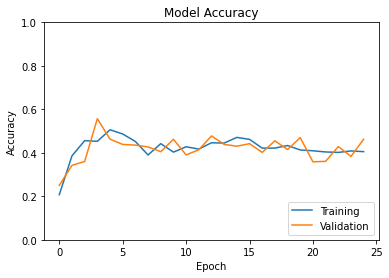

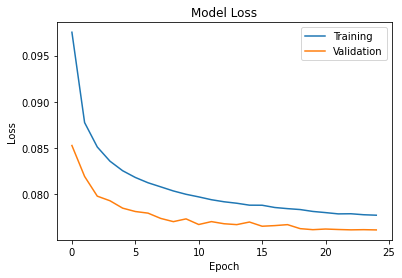

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.ylim(ymin=0)
plt.ylim(ymax=1)
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

#**Save and Load Model**

In [33]:
model.save(
    filepath = './shopee.h5' 
)

In [35]:
from tensorflow.keras.models import load_model

model = load_model('./shopee.h5')

#**Evaluate Model on Train Data**

In [36]:
import re
pred = model.predict(TRAIN_DATA)
train["prediction"] = ""

In [37]:
for index, row in train.iterrows():
    street = ""
    POI = ""
    temp = str(np.argmax(pred[index], axis=1)[:len(row.tokenize)]).replace(" ", "").replace("[", "").replace("]", "")
        
    startIndexStreet = temp.index(max(re.findall(r'[1]*', temp), key=len))
    endIndexStreet = startIndexStreet + len(max(re.findall(r'[1]*', temp), key=len))
    startIndexPOI = temp.index(max(re.findall(r'[0]*', temp), key=len))
    endIndexPOI = startIndexPOI + len(max(re.findall(r'[0]*', temp), key=len))

    if(startIndexStreet != endIndexStreet): 
        endStreet = row["raw_address"].find(row["tokenize"][endIndexStreet-1]) + len(row["tokenize"][endIndexStreet-1])
        street = str(row["raw_address"][startIndexStreet:endStreet])

    if(startIndexPOI != endIndexPOI): 
        endPOI = row["raw_address"].find(row["tokenize"][endIndexPOI-1]) + len(row["tokenize"][endIndexPOI-1])
        POI = str(row["raw_address"][startIndexPOI:endPOI])
        
    train.at[index, "prediction"] = str(POI+"/"+street).strip()

In [38]:
train[["POI/street", "prediction"]].head(10)

,POI/street,prediction
0,/jl kapuk timur delta sili iii lippo cika,uk timur delta sili iii lippo/jl kapuk timur d...
1,/,/aye
2,/siung,/etu siung
3,toko dita/,toko dita/
4,/jl. orde baru,/jl. orde baru
5,toko bb kids/raya samb gede,"samb gede, 299 toko bb kids/raya samb gede"
6,/kem mel raya,/kem mel raya
7,/tela,/tela
8,/gg. i,/gg. i
9,/bunga ncole ix,/bunga ncole ix


#**Submission**

In [39]:
predtest = model.predict(TEST_DATA)
test["POI/street"] = ""

In [40]:
for index, row in test.iterrows():
    street = ""
    POI = ""
    temp = str(np.argmax(pred[index], axis=1)[:len(row.tokenize)]).replace(" ", "").replace("[", "").replace("]", "")
        
    startIndexStreet = temp.index(max(re.findall(r'[1]*', temp), key=len))
    endIndexStreet = startIndexStreet + len(max(re.findall(r'[1]*', temp), key=len))
    startIndexPOI = temp.index(max(re.findall(r'[0]*', temp), key=len))
    endIndexPOI = startIndexPOI + len(max(re.findall(r'[0]*', temp), key=len))

    if(startIndexStreet != endIndexStreet): 
        endStreet = row["raw_address"].find(row["tokenize"][endIndexStreet-1]) + len(row["tokenize"][endIndexStreet-1])
        street = str(row["raw_address"][startIndexStreet:endStreet])

    if(startIndexPOI != endIndexPOI): 
        endPOI = row["raw_address"].find(row["tokenize"][endIndexPOI-1]) + len(row["tokenize"][endIndexPOI-1])
        POI = str(row["raw_address"][startIndexPOI:endPOI])
        
    test.at[index, "POI/street"] = str(POI+"/"+street).strip()

In [41]:
test.head()

,id,raw_address,tokenize,POI/street
0,0,s. par 53 sidanegara 4 cilacap tengah,"[s, par, 53, sidanegara, 4, cilacap, tengah]",53 sidanegara 4 cilacap tengah/s. par 53 sidan...
1,1,"angg per, baloi indah kel. lubuk baja","[angg, per, baloi, indah, kel, lubuk, baja]",/angg
2,2,"asma laun, mand imog,","[asma, laun, mand, imog]",/sma laun
3,3,"ud agung rej, raya nga sri wedari karanganyar","[ud, agung, rej, raya, nga, sri, wedari, karan...",ud agung/
4,4,"cut mutia, 35 baiturrahman","[cut, mutia, 35, baiturrahman]","/cut mutia, 35"


In [42]:
test[["id","POI/street"]].to_csv("submission.csv", index = False)